**Review**
	  
Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did an excellent job overall. The project is accepted. Good luck on the next sprint!

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re

from tqdm.auto import tqdm

import lightgbm as lgb

!pip install transformers
# import PyTorch and transformers libraries
import torch
import transformers
#install wordcloud
!pip install wordcloud 
# import package and its set of stopwords
from wordcloud import WordCloud
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler # for normalizing data

# import metrics
from sklearn import metrics
from sklearn.metrics import f1_score, precision_recall_curve

# import machine learning models
from sklearn.dummy import DummyClassifier # dummy classifier
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.naive_bayes import MultinomialNB # naive bayes classifier
from lightgbm import LGBMClassifier # lightGBM classifier
from sklearn.linear_model import SGDClassifier # stochastic gradient classifier

import sys
import warnings # ignore warnings
warnings.filterwarnings("ignore")

print('Project libraries imported successfully')

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 366 kB 2.3 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Project libraries imported successfully


In [29]:
import spacy

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47331 non-null object
title_type         47331 non-null object
primary_title      47331 non-null object
original_title     47331 non-null object
start_year         47331 non-null int64
end_year           47331 non-null object
runtime_minutes    47331 non-null object
is_adult           47331 non-null int64
genres             47331 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47331 non-null object
rating             47331 non-null int64
sp                 47331 non-null object
pos                47331 non-null int64
ds_part            47331 non-null object
idx                47331 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.2+ MB


- After checking the data we se that it contains:
  - 47331 rows | 17 columns

## EDA

Let's check the number of movies and reviews over years.

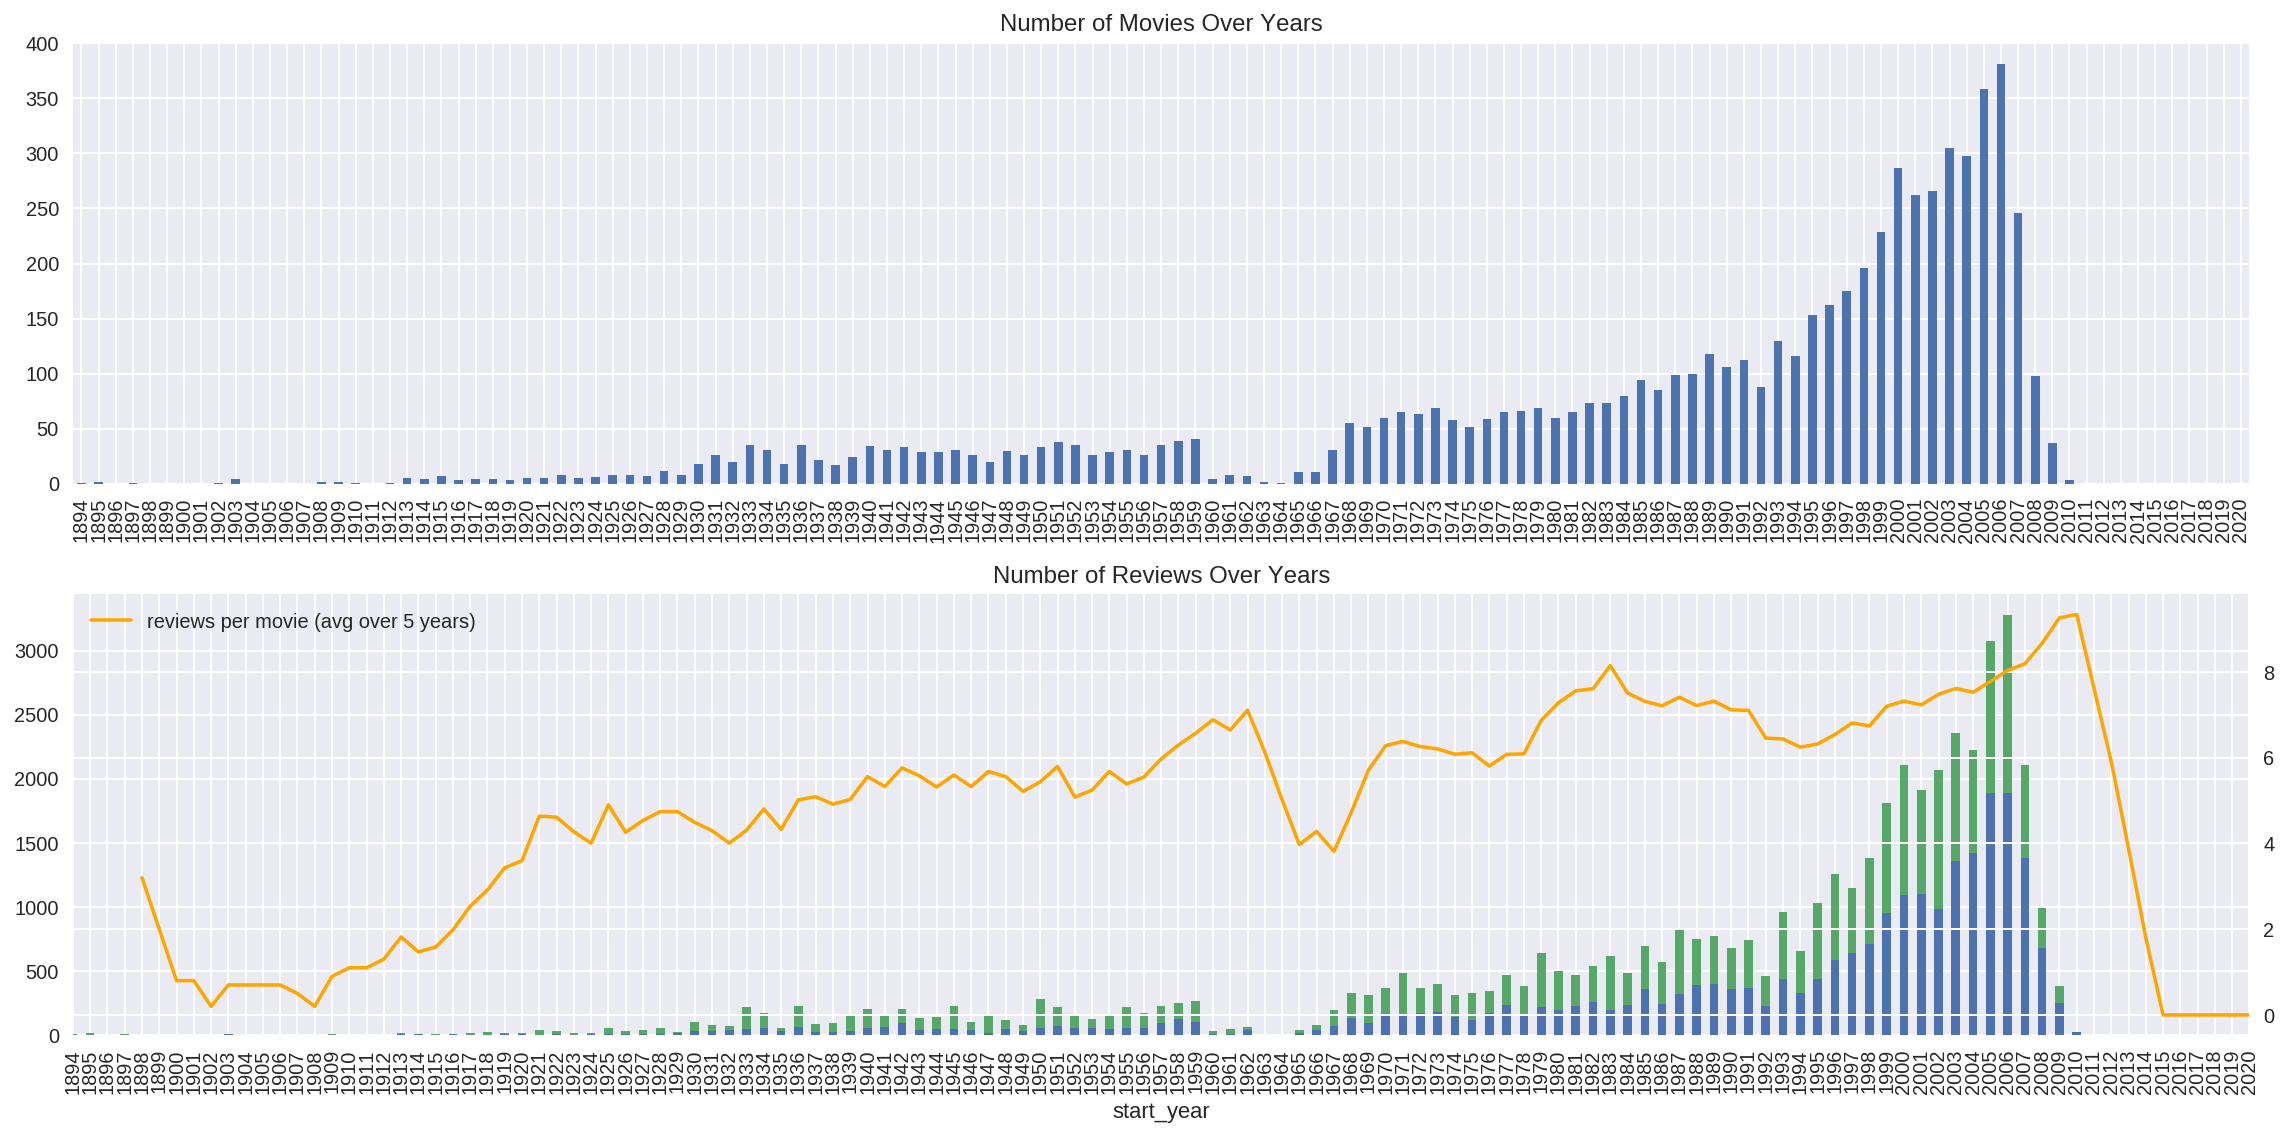

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

We can see here:
- an increase of the movies number till 2006
- a remarkable increase from 1993 to 2006
- Movies reviews are abviously also incrising 

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

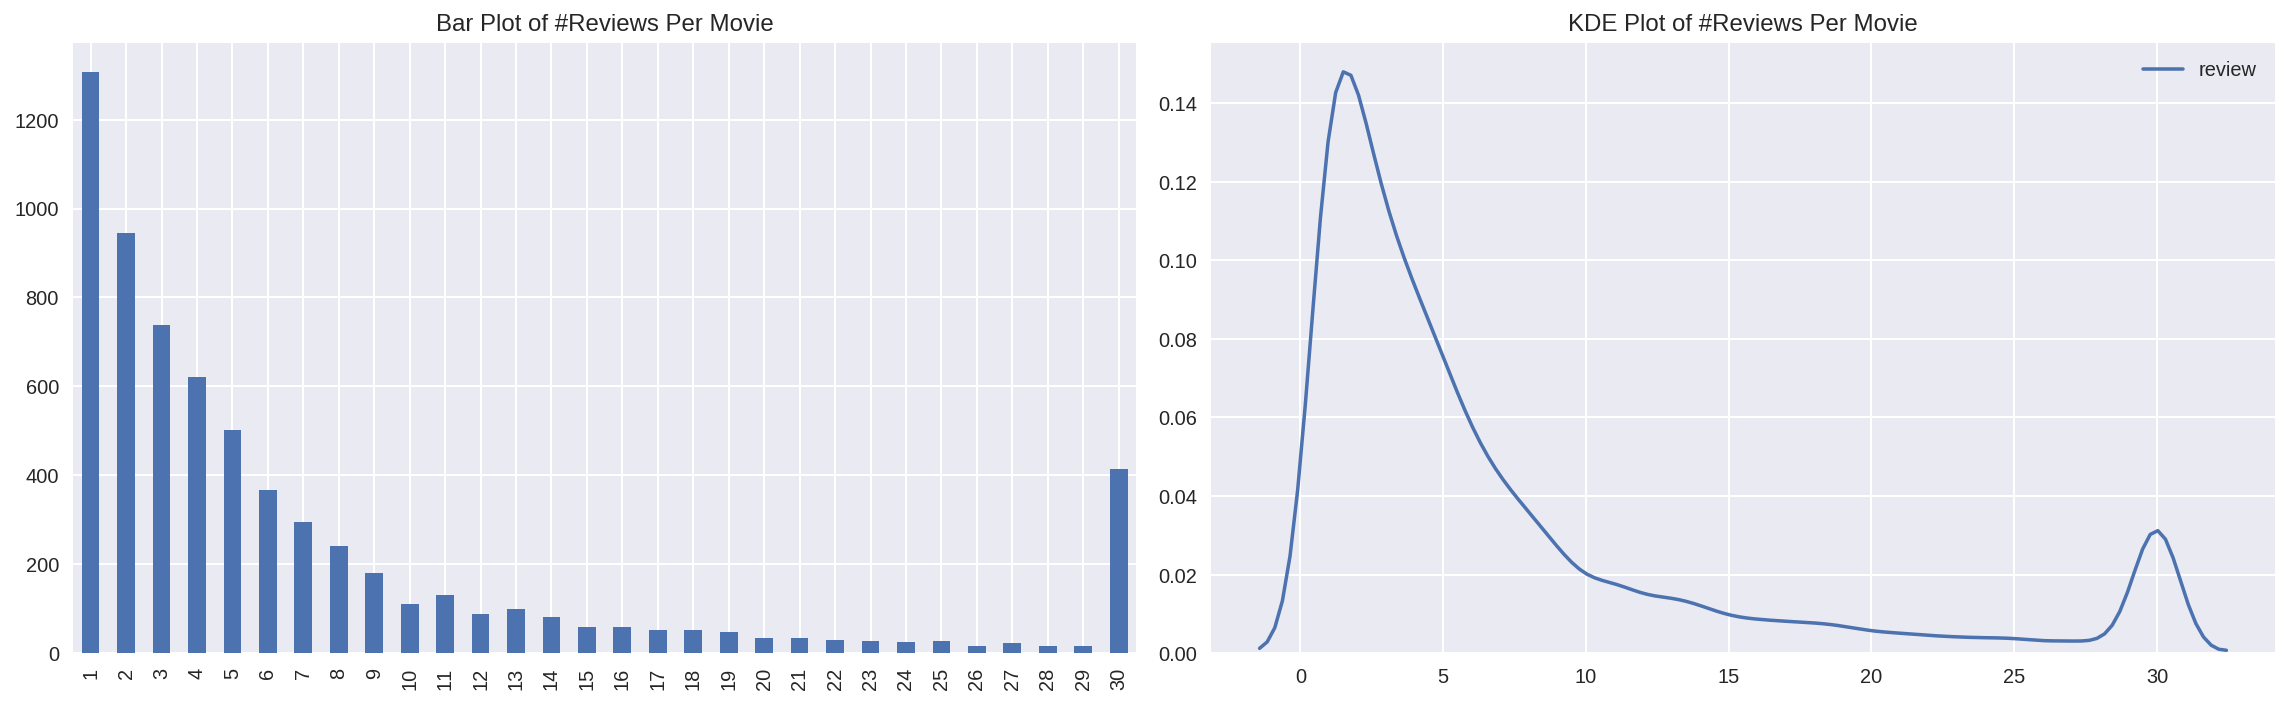

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

- Checking the number of occurences of each label for the `pos` column.

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

- The positive and negative reviews are very close. Which means that teh data is balanced

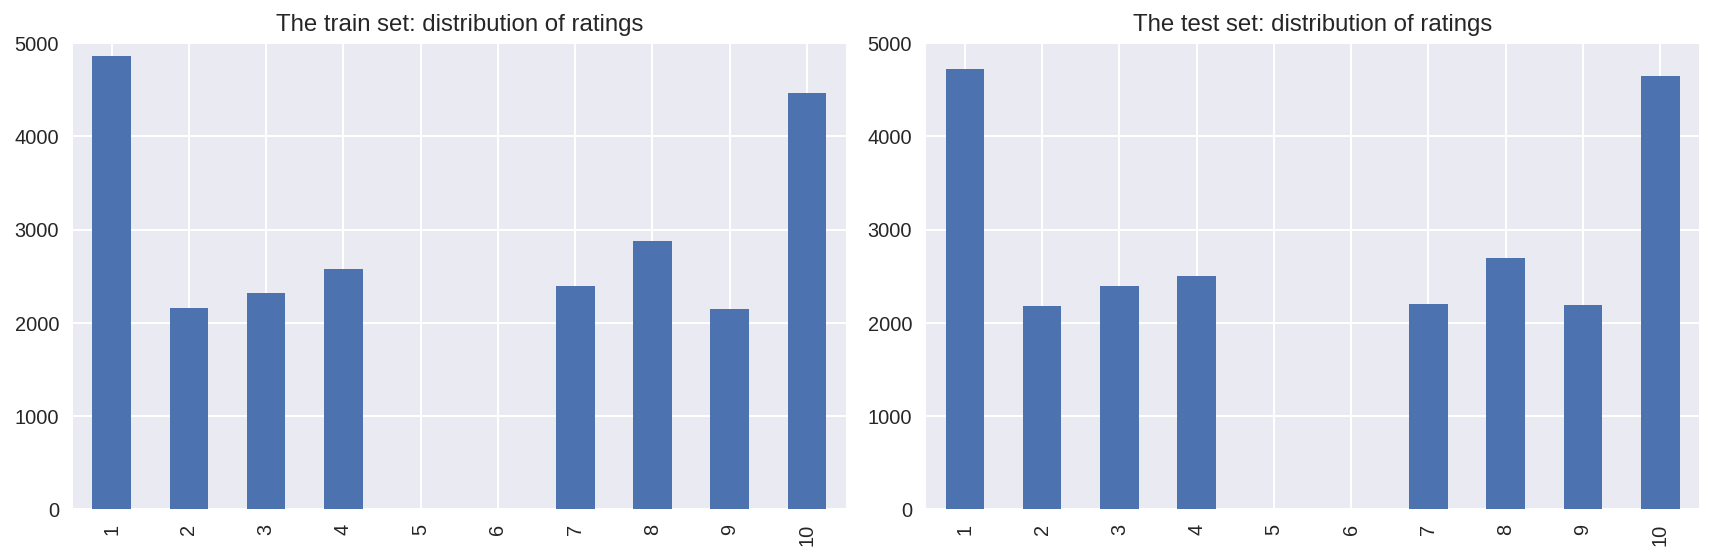

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

- Train and test set's distributions look similar.

Distribution of negative and positive reviews over the years for two parts of the dataset

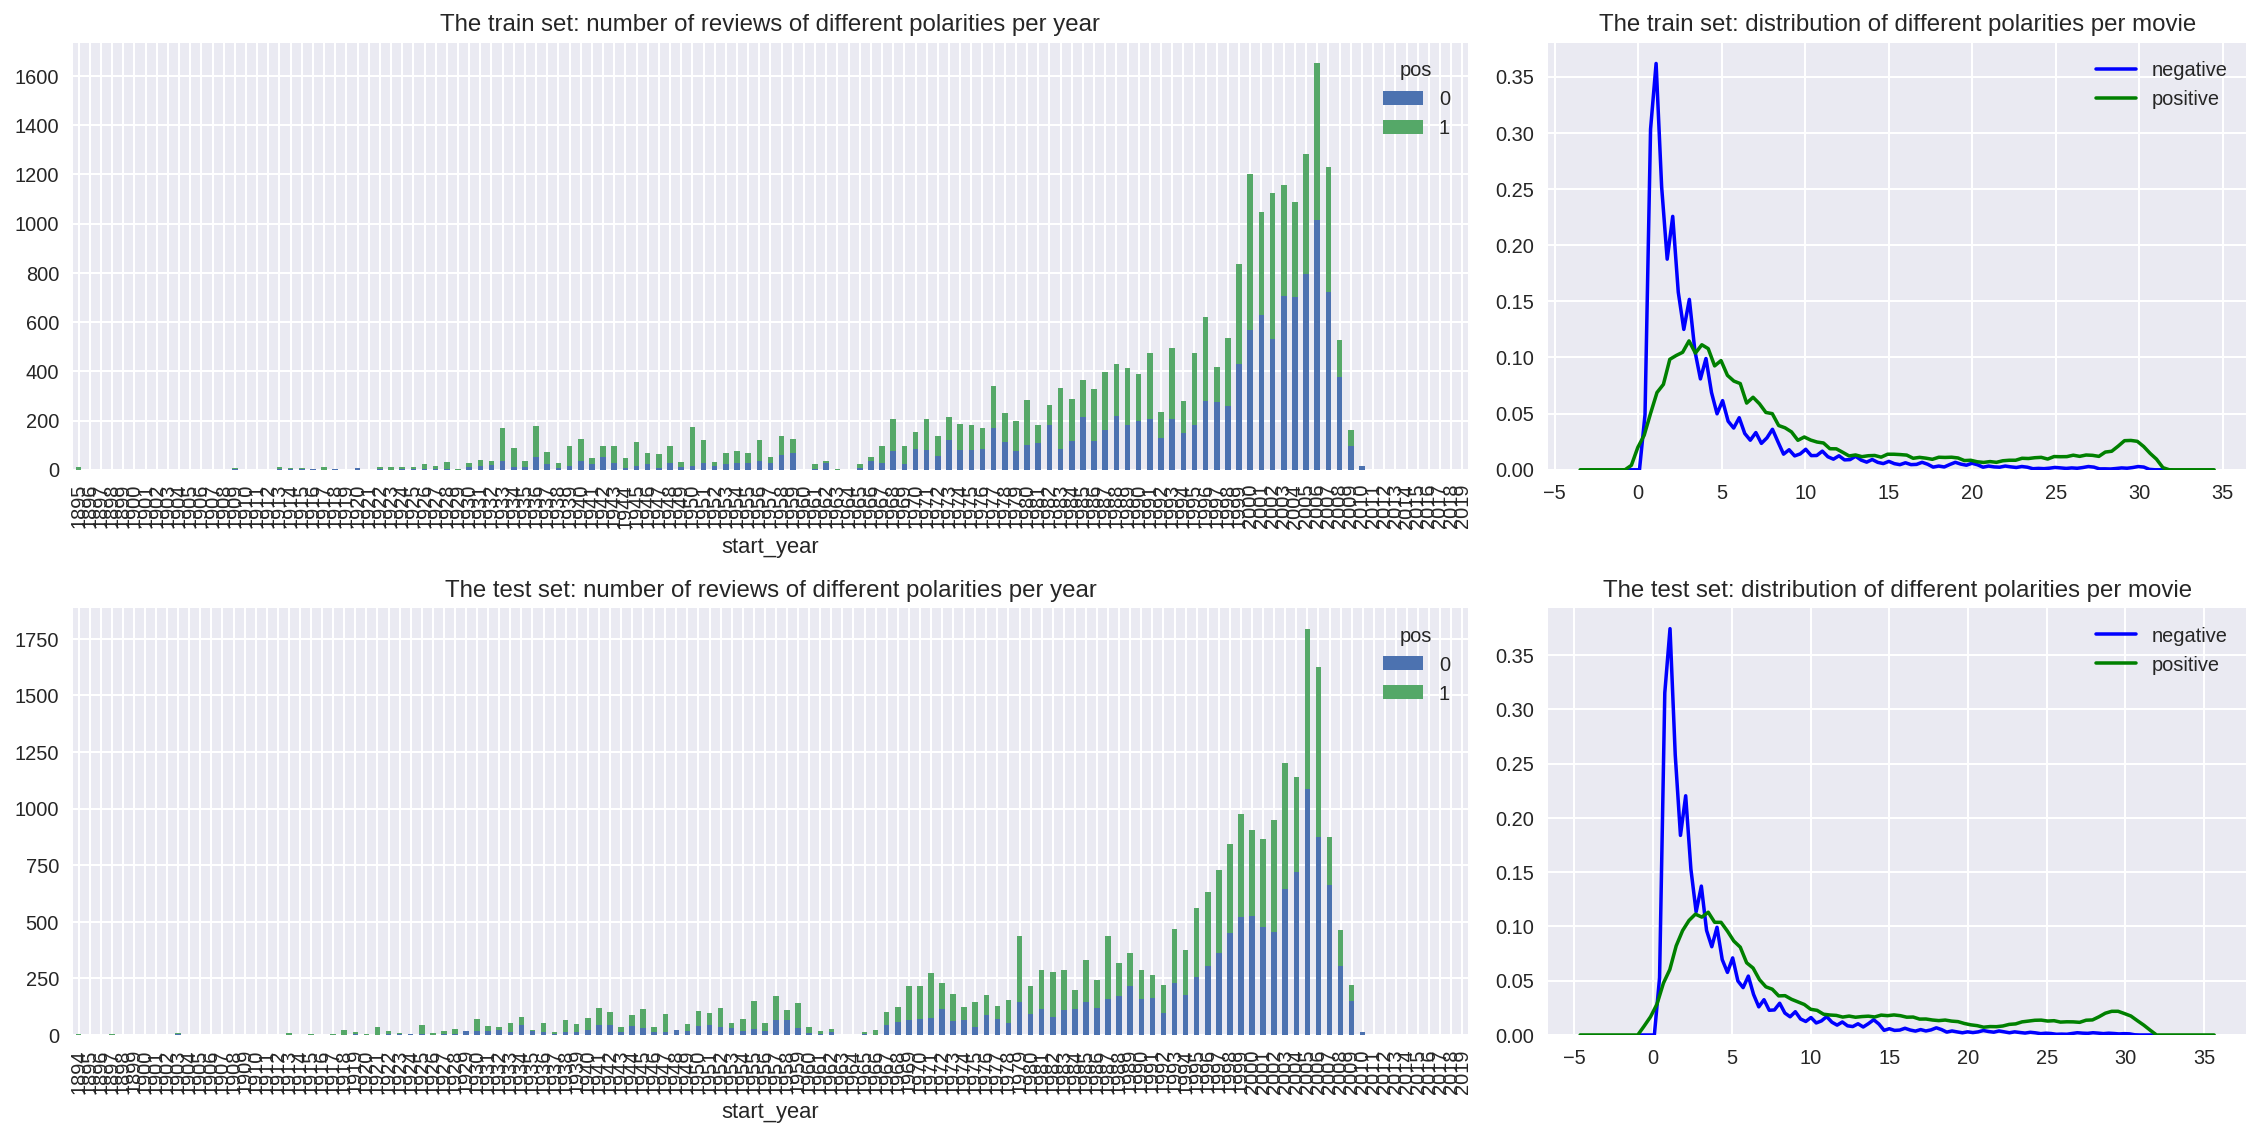

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Alright, you explored the data and made some interesting observations!
	  
</div>

In [13]:
#Cleaning the data from non standard characters
def clean_data(data):
    clean_data = re.sub(r"[^a-zA-Z']", " ", data)
    clean_data = " ".join(clean_data.split())
    return clean_data.lower()

In [14]:
df_reviews['review'] = df_reviews['review'].apply(clean_data)
df_reviews['review'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review, dtype: object

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Normalization looks good
	  
</div>

In [15]:
positive_reviews = df_reviews[df_reviews['pos'] == 1]
positive_reviews = positive_reviews.review

negative_reviews = df_reviews[df_reviews['pos'] == 0]
negative_reviews = negative_reviews.review

- After data cleansing and visualization, we will move to the evaluation

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [16]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [17]:
df_reviews['review_norm'] = df_reviews['review'].apply(clean_data)
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        i'm totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought i'd say this about a biopic bu...
47329    spirit and chaos is an artistic biopic of miya...
47330    i'll make this brief this was a joy to watch i...
Name: review_norm, Length: 47331, dtype: object

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
The data in 'review' column was already normalized, but ok :)
	  
</div>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [18]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

y_train = df_reviews_train['pos']
y_test = df_reviews_test['pos']

X_train = df_reviews_train['review_norm']
X_test = df_reviews_test['review_norm']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [19]:
%%time
# dummy classifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

CPU times: user 2.17 ms, sys: 176 µs, total: 2.35 ms
Wall time: 1.31 ms


DummyClassifier(constant=None, random_state=None, strategy='stratified')

          train  test
Accuracy    0.5  0.50
F1          0.5  0.50
APS         0.5  0.50
ROC AUC     0.5  0.51


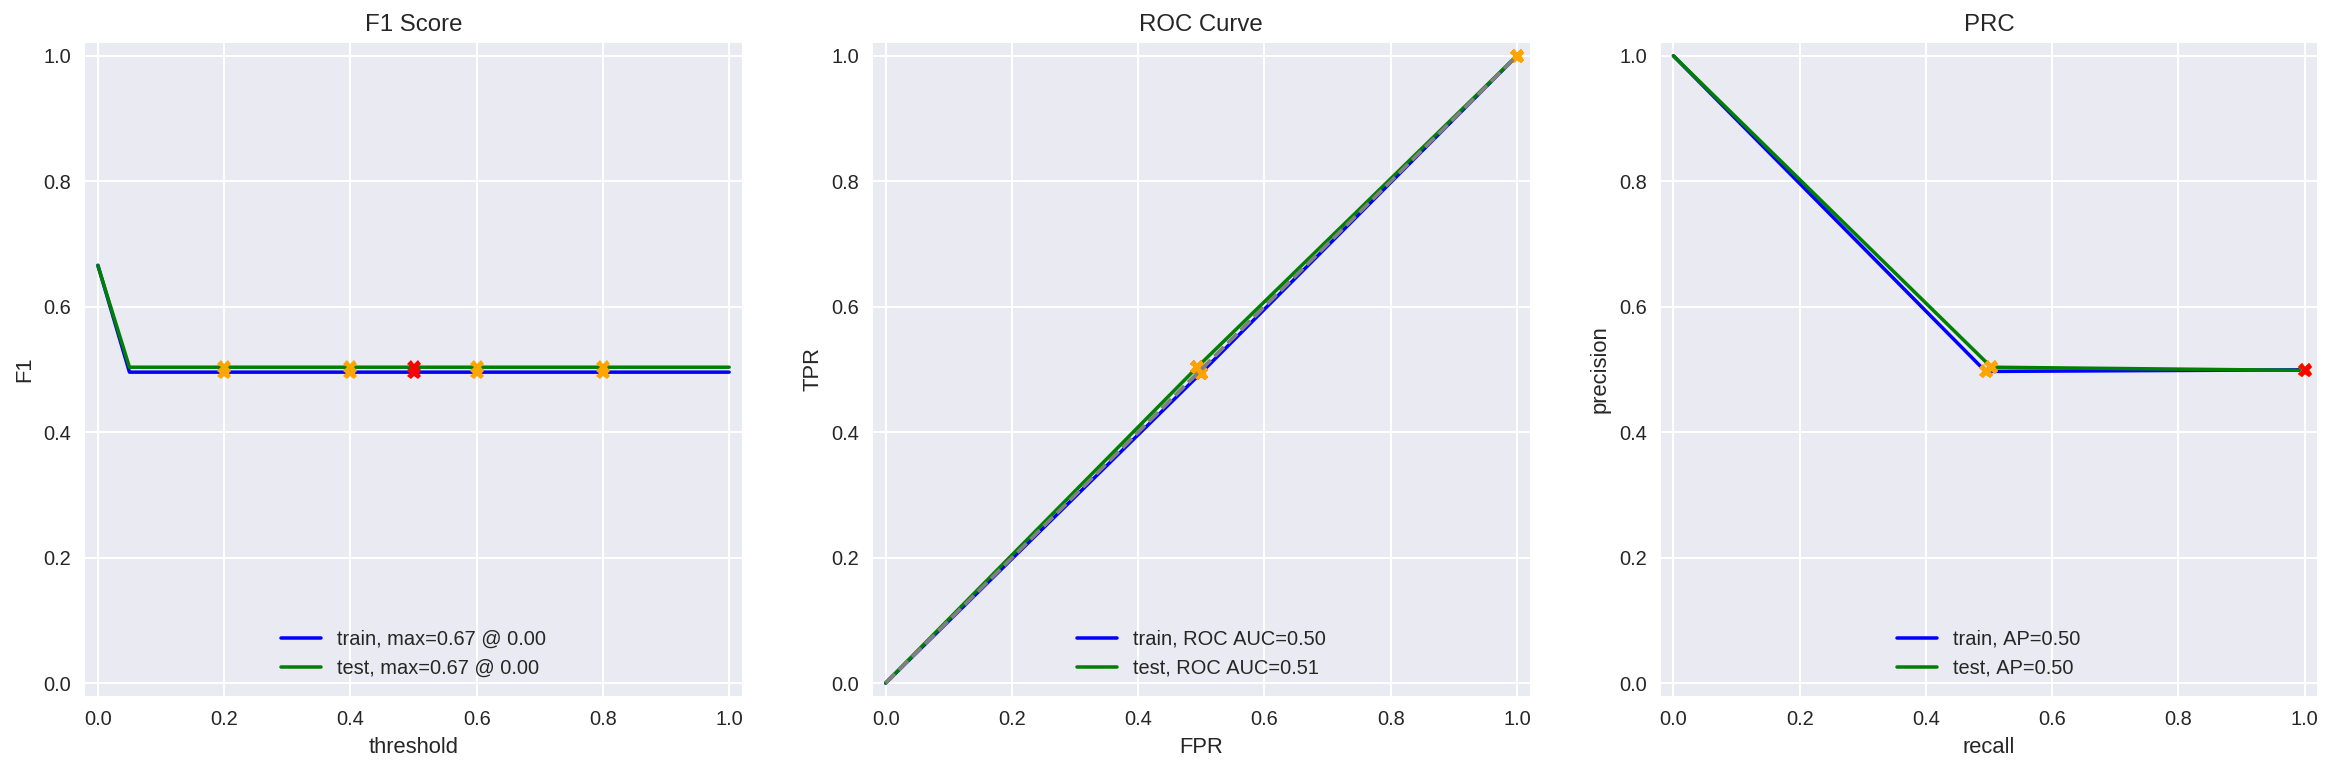

In [20]:
evaluate_model(dummy_clf, X_train, y_train, X_test, y_test)

Dummy classifier gave us a:
- accuracy of 50% 
- F1 score of 0.49.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Ok, there's a baseline!
	  
</div>

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [21]:
#pre-processing with NLTK
stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words) # create a counter

# function to tokenize and lemmatize text using NLTK
def lemmatize_nltk(text):
    lemmatizer  = WordNetLemmatizer() # create a lemmatization object
    tokens = word_tokenize(text.lower()) # split text into tokens
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    lemmatized = " ".join(lemmas) 
    return lemmatized

In [22]:
#lemmatization
df_reviews_train['review_nltk'] = X_train.apply(lemmatize_nltk)
df_reviews_test['review_nltk'] = X_test.apply(lemmatize_nltk)

# recalculate TF-IDF for train and test samples
nltk_X_train = count_tf_idf.fit_transform(df_reviews_train['review_nltk'])
nltk_X_test = count_tf_idf.transform(df_reviews_test['review_nltk'])

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Lemmatization and vectorization with TF-IDF are applied correctly
	  
</div>

### Logistic Regression with NLTK

In [23]:
%%time
# train logistic regression model
logistic_clf = LogisticRegression(random_state=12345, solver='liblinear')
logistic_clf.fit(nltk_X_train, y_train)

CPU times: user 3.42 s, sys: 2.69 s, total: 6.11 s
Wall time: 6.11 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


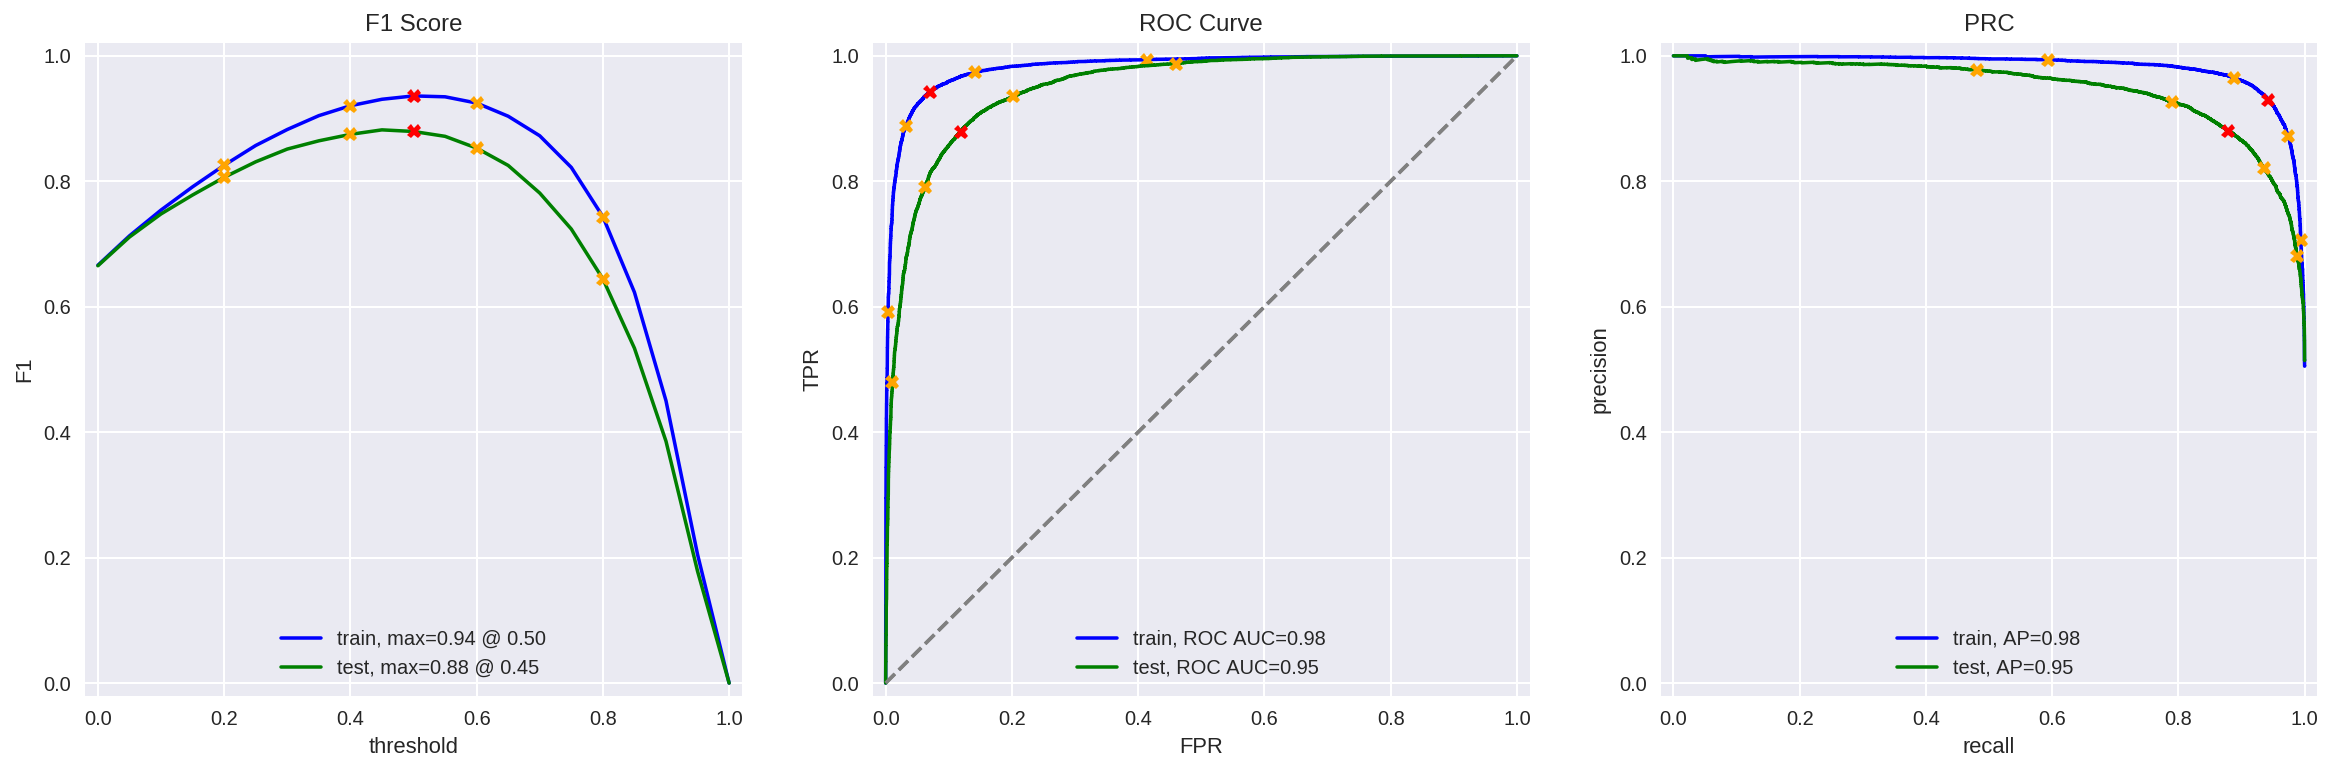

In [24]:
evaluate_model(logistic_clf, nltk_X_train, y_train, nltk_X_test, y_test)

Logistic regerssion with preprocessing gave us:
- accuracy of 0.88
- F1 score of 0.88

Required F1 score is achieved, though the classifier seems overfitting

### LightGBM Classifier with NLTK

In [25]:
%%time
# train lightGBM classifier
lgbm_clf = lgb.LGBMClassifier(random_state=12345)
lgbm_clf.fit(nltk_X_train, y_train)

CPU times: user 1min 49s, sys: 677 ms, total: 1min 49s
Wall time: 1min 51s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

          train  test
Accuracy   0.91  0.86
F1         0.92  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


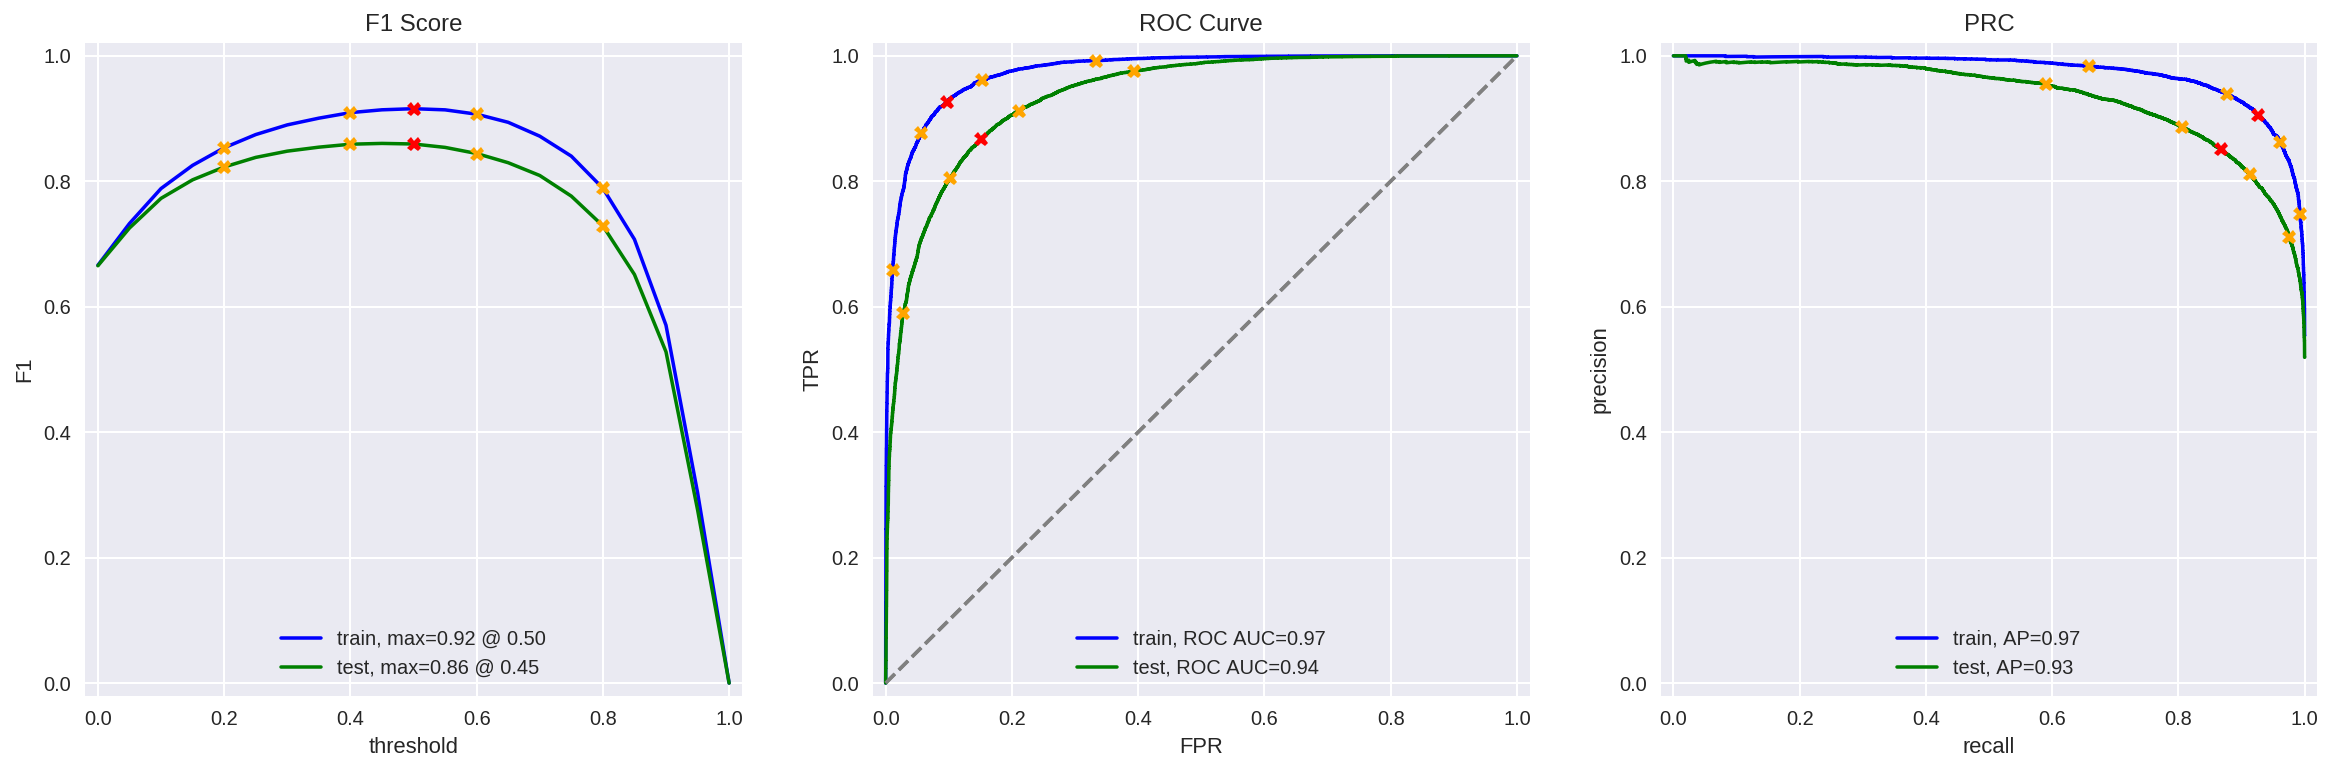

In [27]:
evaluate_model(lgbm_clf, nltk_X_train, y_train, nltk_X_test, y_test)

- LGBM achieved the required F1 score though the execution time for fitting was slow

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Great, you trained a couple of different models using vectorized texts as features
	  
</div>

### SpaCy and TF-IDF

In [30]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [31]:
def lemmatize_spacy(text):
    doc = nlp(text.lower())
    lemmas = []
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    lemmas = [token.lemma_ for token in doc]
    lemmatize_spacy = " ".join(lemmas)
    return lemmatize_spacy

In [32]:
# apply lemmatization to features with spaCy
df_reviews_train['review_spacy'] = X_train.apply(lemmatize_spacy)
df_reviews_test['review_spacy'] = X_test.apply(lemmatize_spacy)

# recalculate TF-IDF for train and test samples
spacy_X_train = count_tf_idf.fit_transform(df_reviews_train['review_spacy'])
spacy_X_test = count_tf_idf.transform(df_reviews_test['review_spacy'])

<div class="alert alert-warning">
<b>Reviewer's comment</b>
	  
Lemmatization with spacy is also applied correctly, but you should really use a different instance of TfIdfVectorizer, instead of fit_transforming the same one.
	  
</div>

### Logistic Regression Classifier with spaCy

In [33]:
%%time
# train logistic regression model
logistic_clf_spacy = LogisticRegression(random_state=12345, solver='liblinear')
logistic_clf_spacy.fit(spacy_X_train, y_train)

CPU times: user 3.75 s, sys: 3.04 s, total: 6.78 s
Wall time: 6.93 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


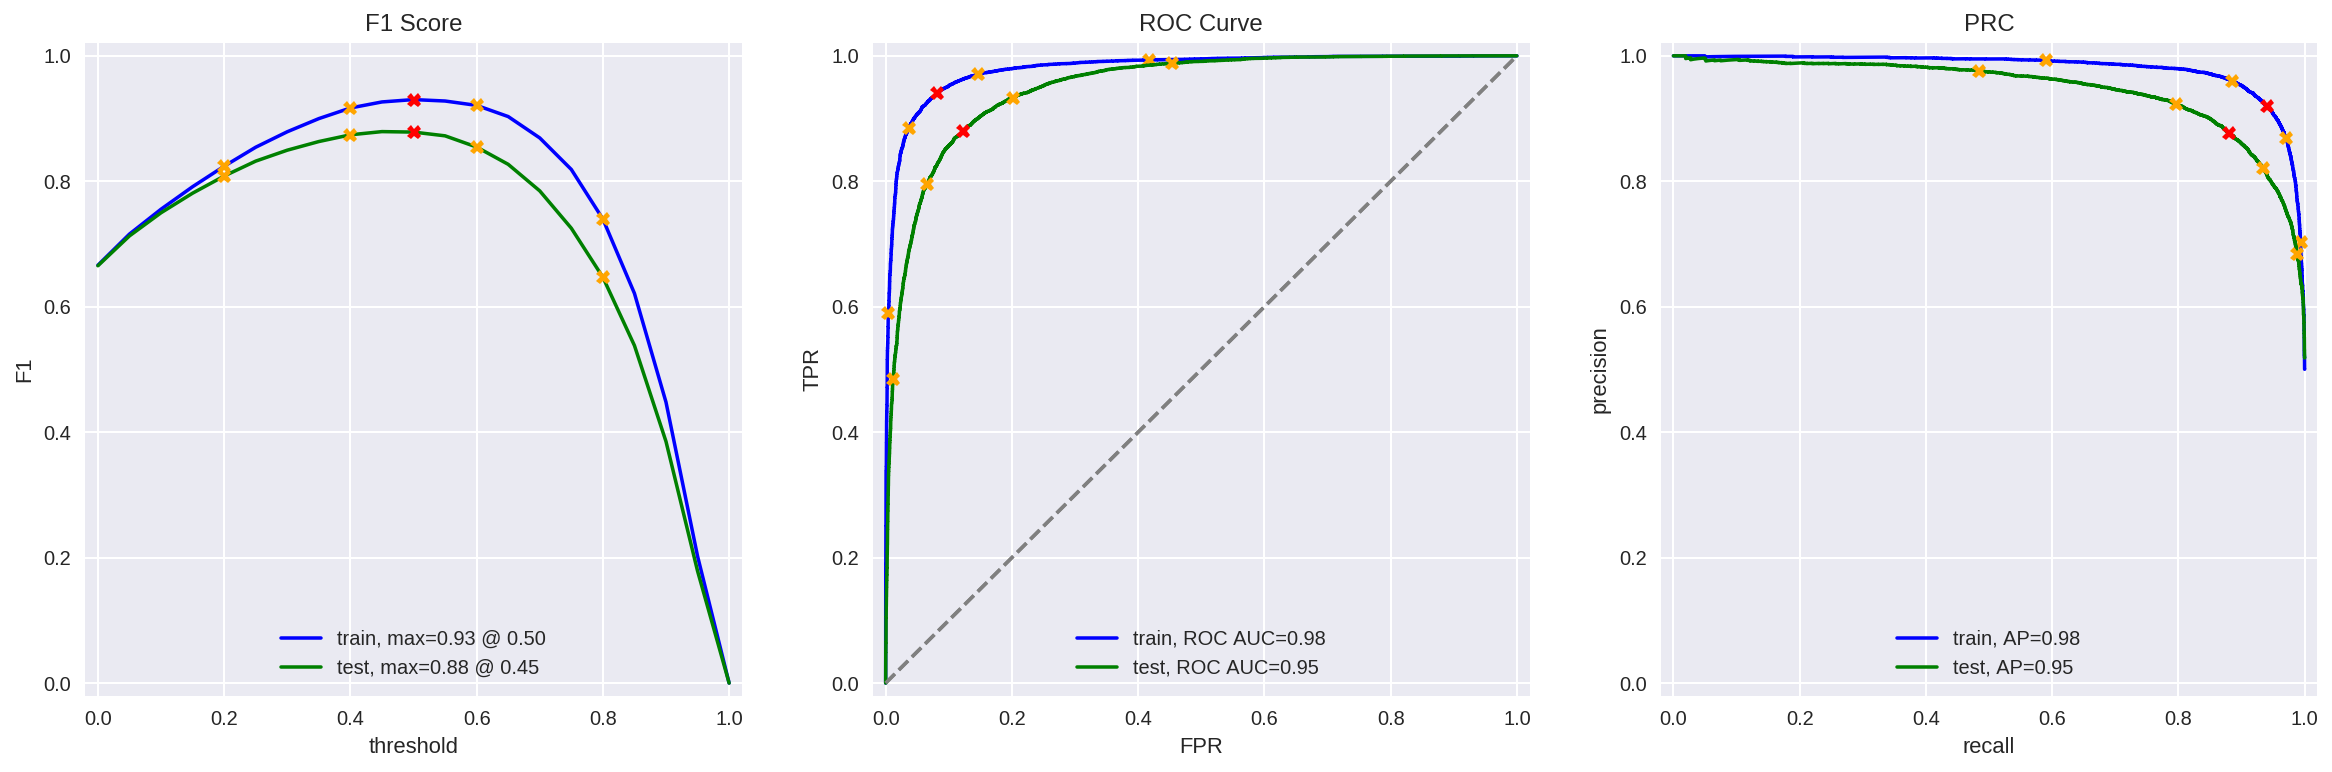

In [34]:
evaluate_model(logistic_clf_spacy, spacy_X_train, y_train, spacy_X_test, y_test)

- Logistic regression classifier achieved an F1 score of 0.88. and an accuracy of 0.88 

### LightGBM Classifier with spaCy

In [35]:
%%time
# train lightGBM classifier
lgbm_clf_spacy = lgb.LGBMClassifier(random_state=12345)
lgbm_clf_spacy.fit(spacy_X_train, y_train)

CPU times: user 1min 42s, sys: 343 ms, total: 1min 42s
Wall time: 1min 44s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


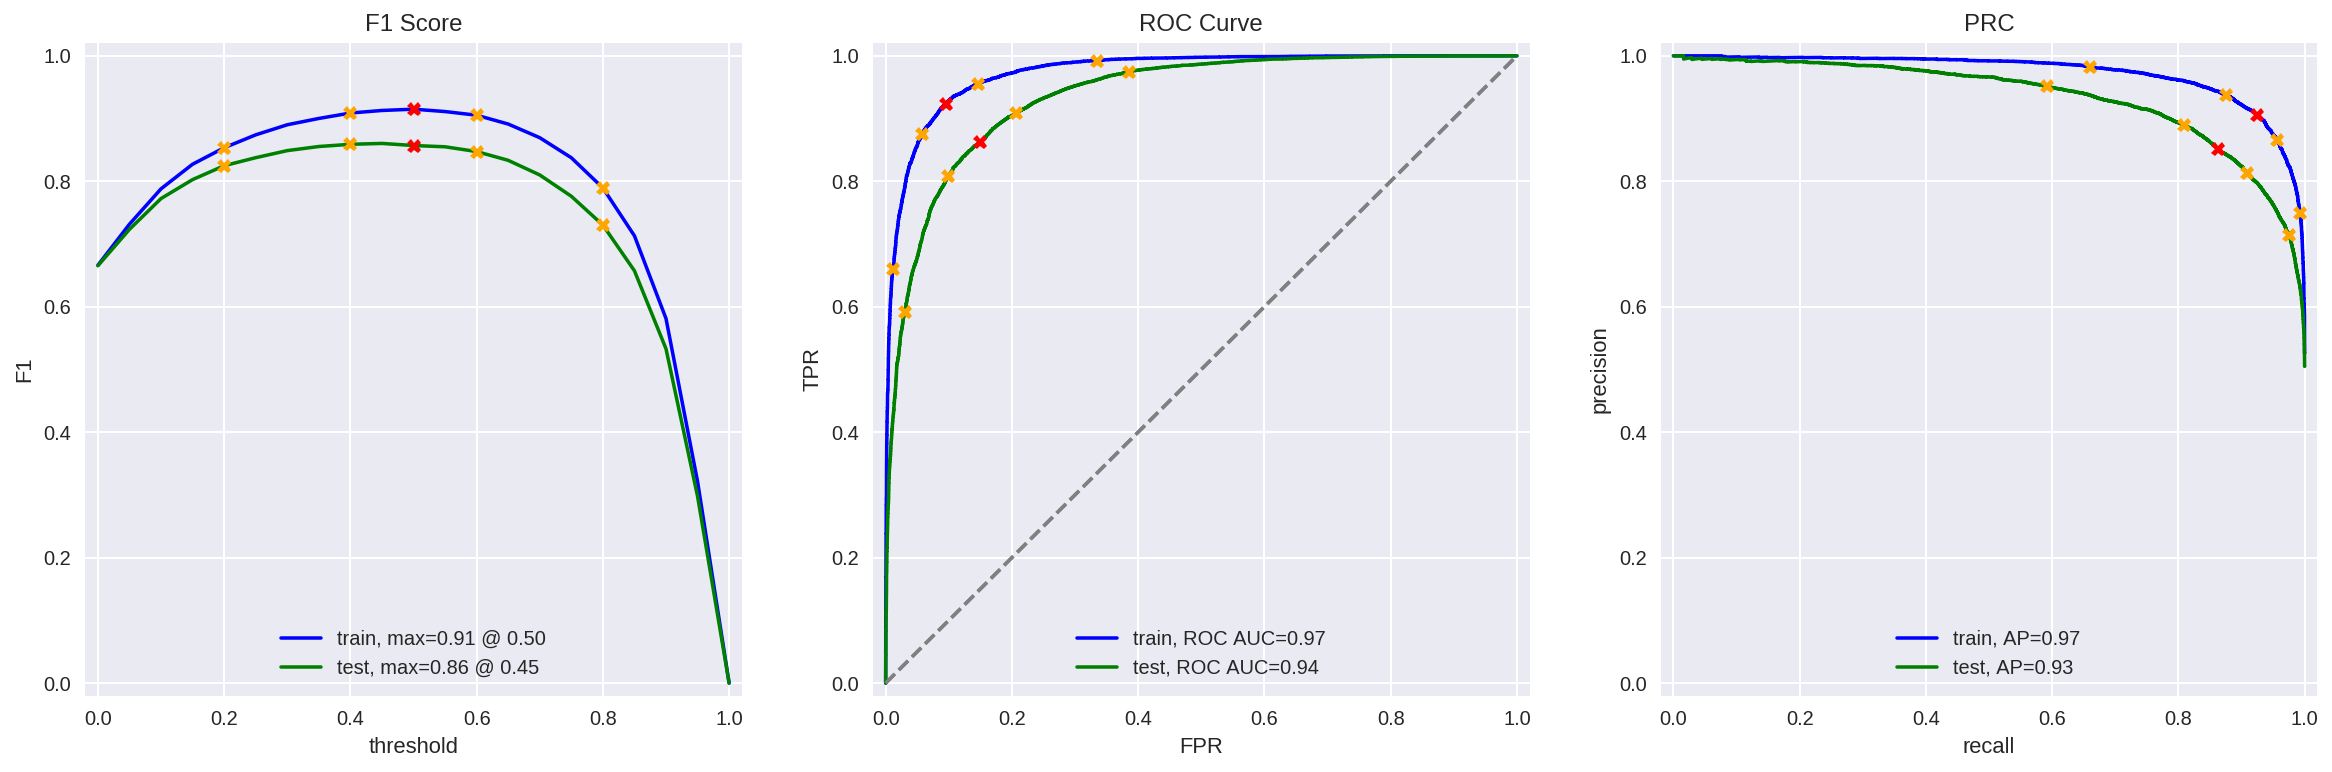

In [36]:
evaluate_model(lgbm_clf_spacy, spacy_X_train, y_train, spacy_X_test, y_test)

-LGBM achieved the riquired F1 score which is 0.86 and a good accuracy of 86%, also the fitting was fast.

### Stocastic Gradient Descent with spaCy

In [59]:
%%time
# train sgd classifier
sgd_clf_spacy = SGDClassifier(random_state=12345, loss='log')
sgd_clf_spacy.fit(spacy_X_train, y_train)

CPU times: user 194 ms, sys: 98.7 ms, total: 293 ms
Wall time: 249 ms


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=12345, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

          train  test
Accuracy   0.91  0.88
F1         0.91  0.88
APS        0.97  0.94
ROC AUC    0.97  0.95


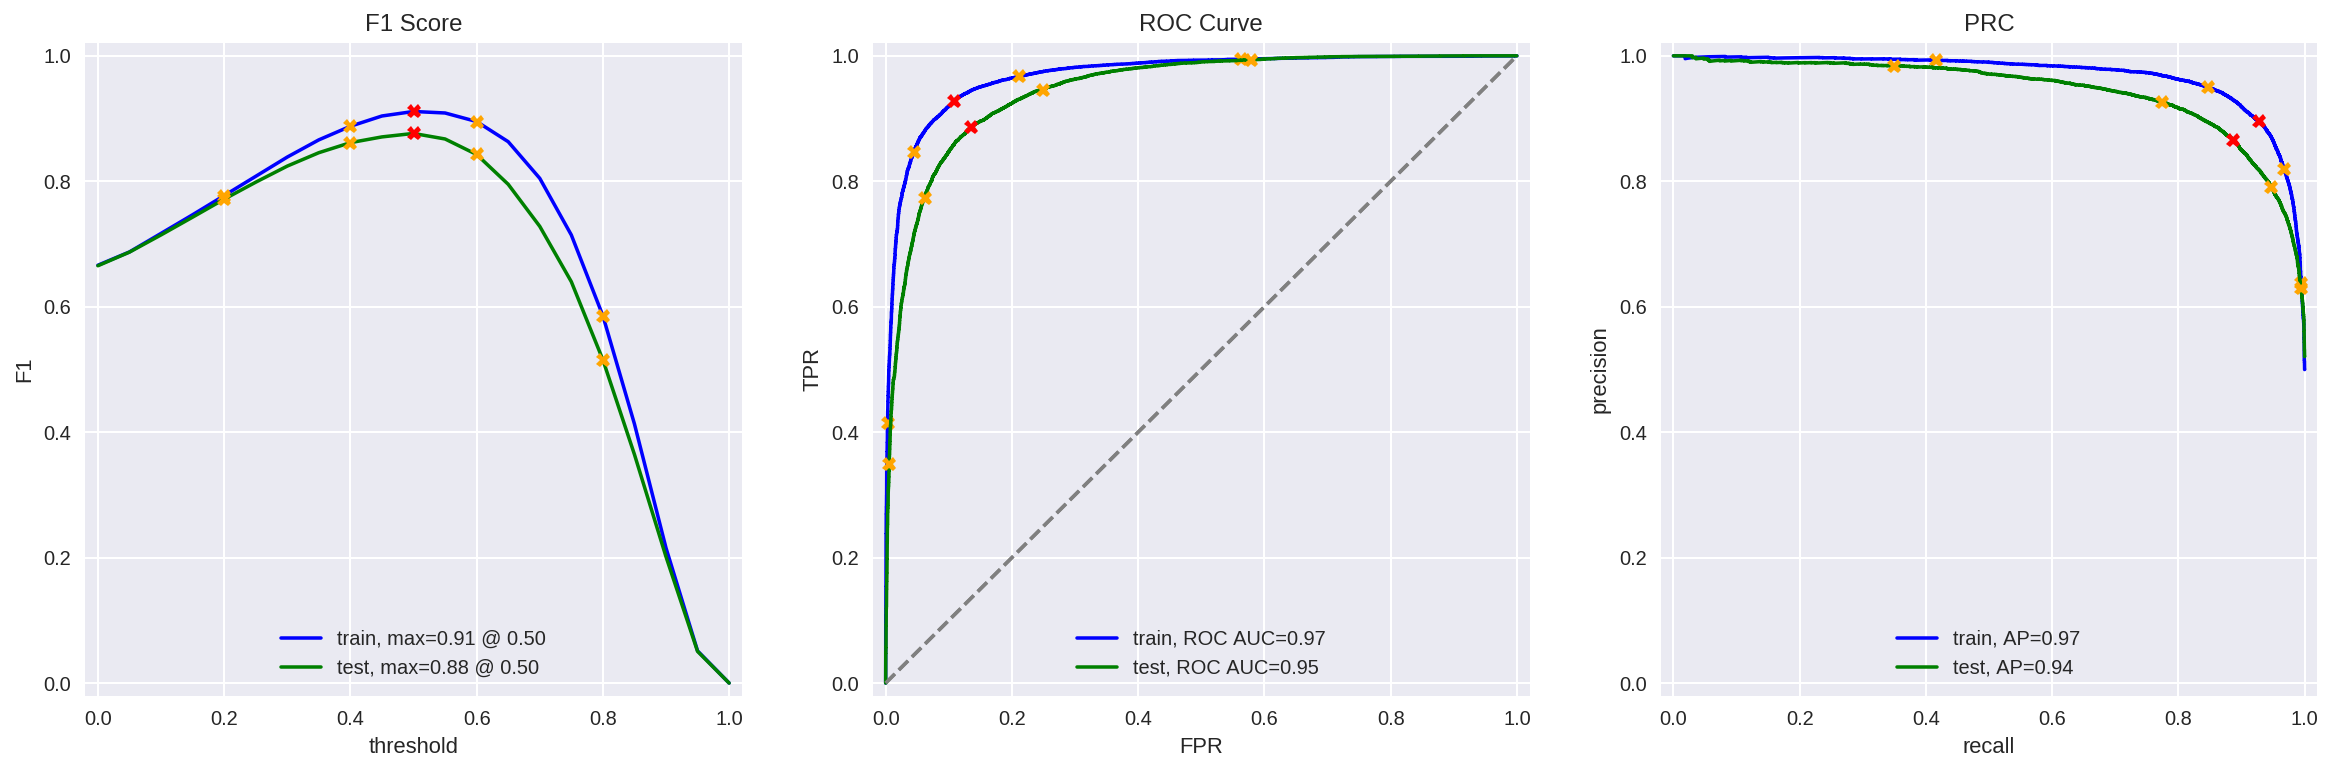

In [60]:
evaluate_model(sgd_clf_spacy, spacy_X_train, y_train, spacy_X_test, y_test)

- SGD is more fast to fit the model, and achieved the required F1 score of 0.88, withoud overfitting.
- in this case we can consider it the best so far.

**Conclusion**
- We can conclude that the best model in our case is SDG classifier with spaCy, taking into account the F1 score, accuracy, execution time, and overfitting on the train set.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Excellent!
	  
</div>

## Preprocessing with BERT

In [38]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [42]:
max_sample_size = 500

In [43]:
# function to preprocess for BERT
def BERT_text_to_embeddings(texts, max_length=512, batch_size = 25, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []
    max_sample_size = 500 #texts.shape[0]

    # text to padded ids of tokens along with their attention masks
    for input_text in texts.iloc[:max_sample_size]['review']:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # create attention_mask_batch
        attention_mask_batch = torch.LongTensor(
            attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [44]:
%%time
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
X_BERT_train = BERT_text_to_embeddings(df_reviews_train, force_device='cpu')
y_BERT_train = df_reviews_train.iloc[:max_sample_size]['pos']

Using the cpu device.



CPU times: user 23min 8s, sys: 6min 24s, total: 29min 33s
Wall time: 29min 35s


In [45]:
print(df_reviews_train['review_norm'].shape)
print(X_BERT_train.shape)
print(y_BERT_train.shape)

(23796,)
(500, 768)
(500,)


In [46]:
%%time
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
X_BERT_test = BERT_text_to_embeddings(df_reviews_test, force_device='cpu')
y_BERT_test = df_reviews_test.iloc[:max_sample_size]['pos']

Using the cpu device.



CPU times: user 22min 17s, sys: 6min 30s, total: 28min 47s
Wall time: 28min 49s


In [47]:
print(df_reviews_test['review_norm'].shape)
print(X_BERT_test.shape)
print(y_BERT_test.shape)

(23535,)
(500, 768)
(500,)


In [48]:
# normalize features to avoid value error in the naïve bayes classifier
scaler = MinMaxScaler()
scaler.fit(X_BERT_train)
# transform the training set and the test set using transform()
X_BERT_train = scaler.transform(X_BERT_train)
X_BERT_test = scaler.transform(X_BERT_test)

### Logistic Regression Classifier with BERT

In [49]:
%%time
# train logistic regression model
logistic_clf_BERT = LogisticRegression(random_state=12345, solver='liblinear')
logistic_clf_BERT.fit(X_BERT_train, y_BERT_train)

CPU times: user 49 ms, sys: 1.07 ms, total: 50.1 ms
Wall time: 49 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

          train  test
Accuracy   0.99  0.82
F1         0.99  0.83
APS        1.00  0.90
ROC AUC    1.00  0.90


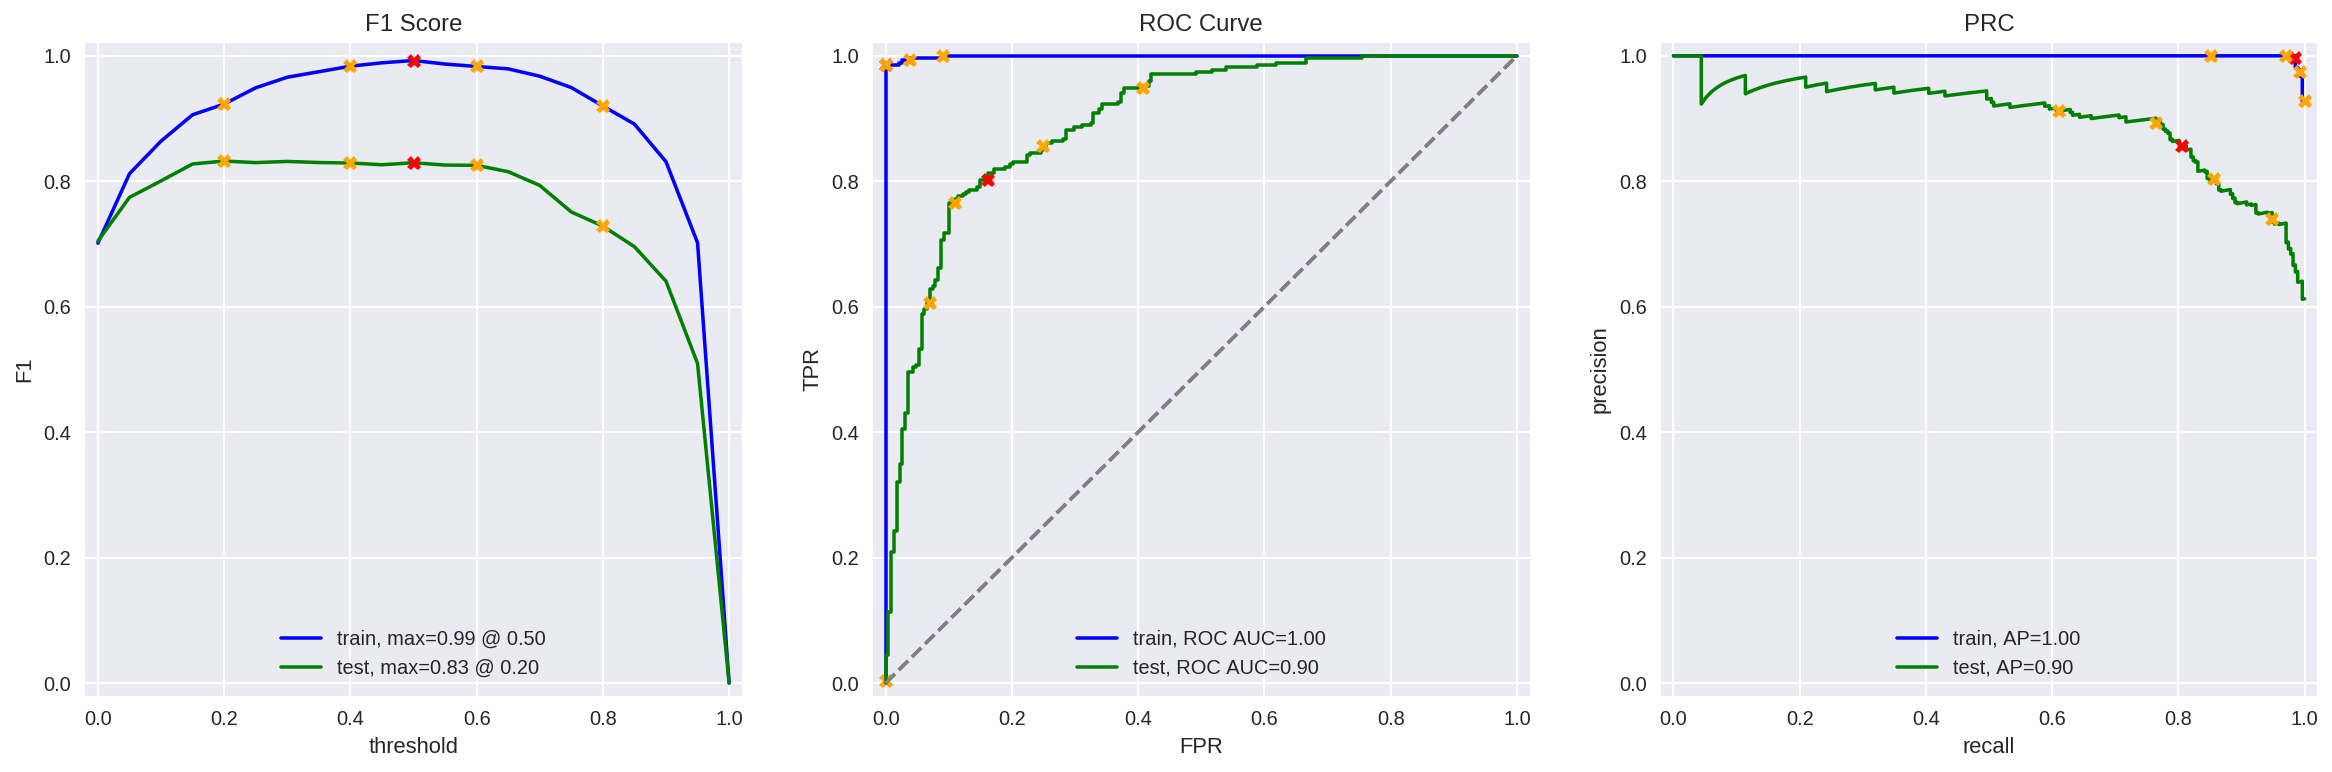

In [50]:
evaluate_model(logistic_clf_BERT, X_BERT_train, y_BERT_train, X_BERT_test, y_BERT_test)

### LightGBM Classifier with BERT

In [51]:
%%time
# train lightGBM classifier
lgbm_clf_BERT = lgb.LGBMClassifier(random_state=12345)
lgbm_clf_BERT.fit(X_BERT_train, y_BERT_train)

CPU times: user 7.31 s, sys: 162 ms, total: 7.47 s
Wall time: 7.47 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

          train  test
Accuracy    1.0  0.78
F1          1.0  0.80
APS         1.0  0.87
ROC AUC     1.0  0.86


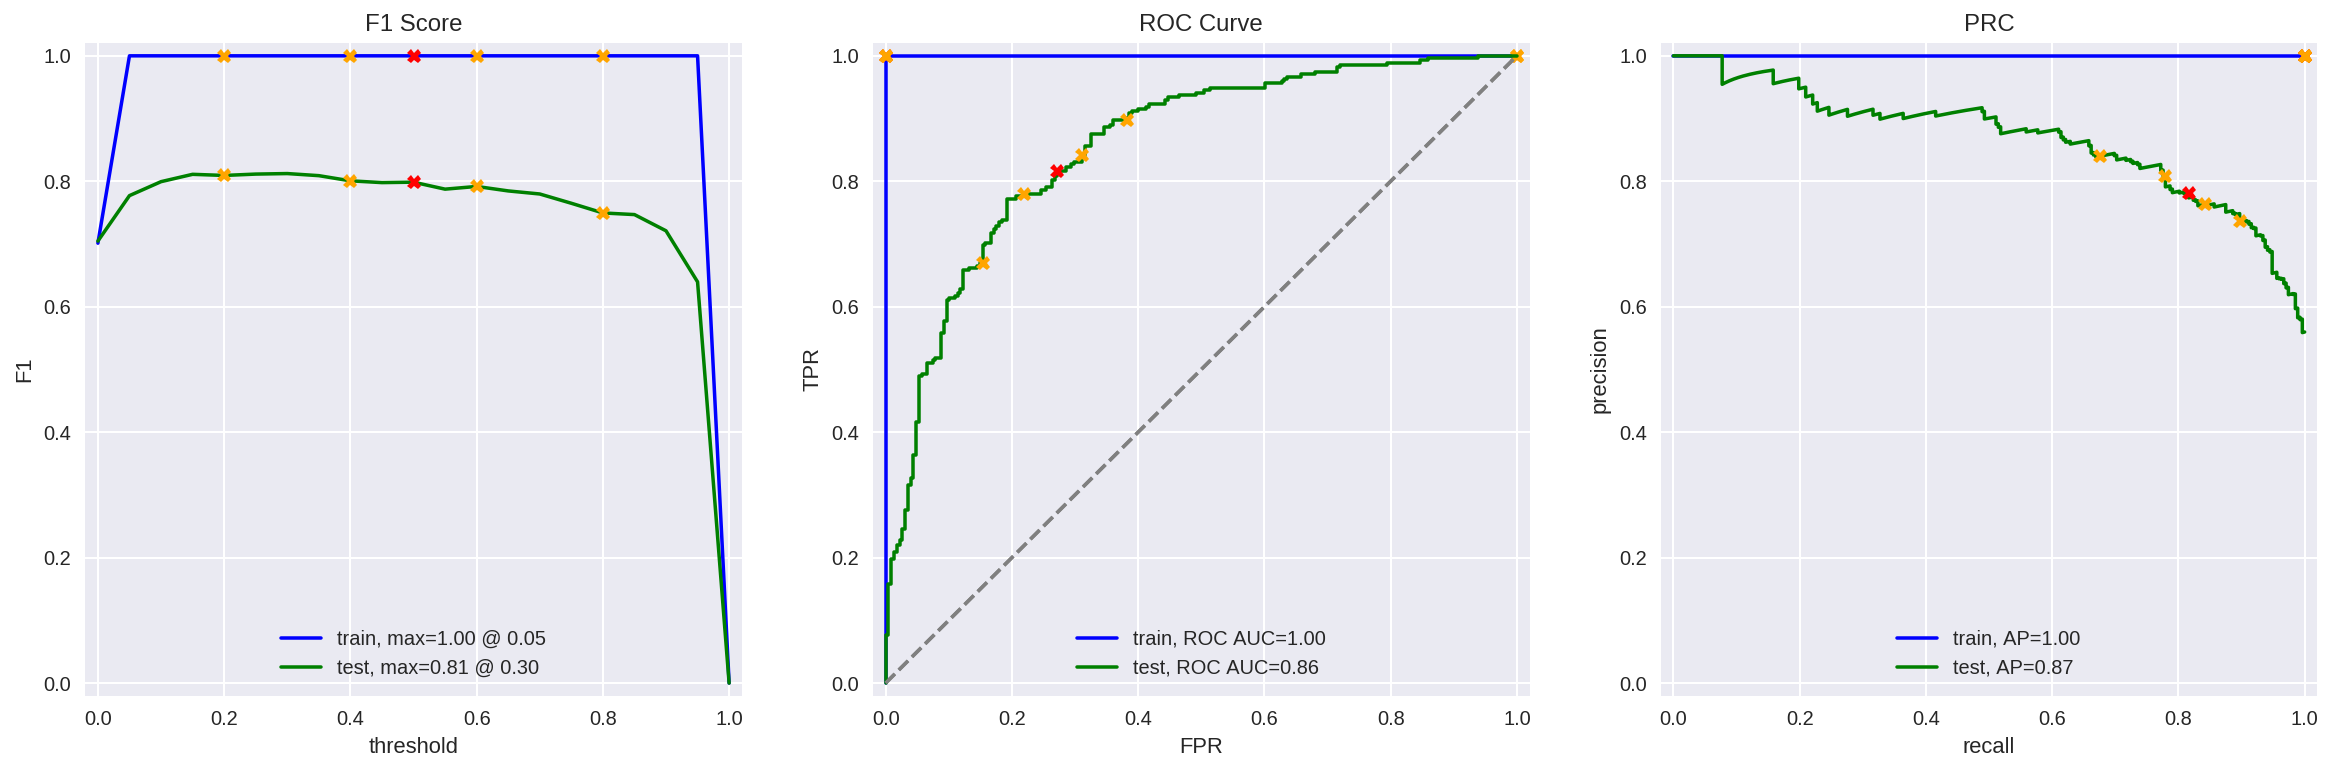

In [52]:
evaluate_model(lgbm_clf_BERT, X_BERT_train, y_BERT_train, X_BERT_test, y_BERT_test)

### Stochastic Gradient Descent with BERT

In [53]:
%%time
# train sgd classifier
sgd_clf_BERT = SGDClassifier(random_state=12345, loss='log')
sgd_clf_BERT.fit(X_BERT_train, y_BERT_train)

CPU times: user 42.2 ms, sys: 1.29 ms, total: 43.5 ms
Wall time: 42.3 ms


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=12345, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

          train  test
Accuracy   0.99  0.82
F1         0.99  0.84
APS        1.00  0.87
ROC AUC    1.00  0.89


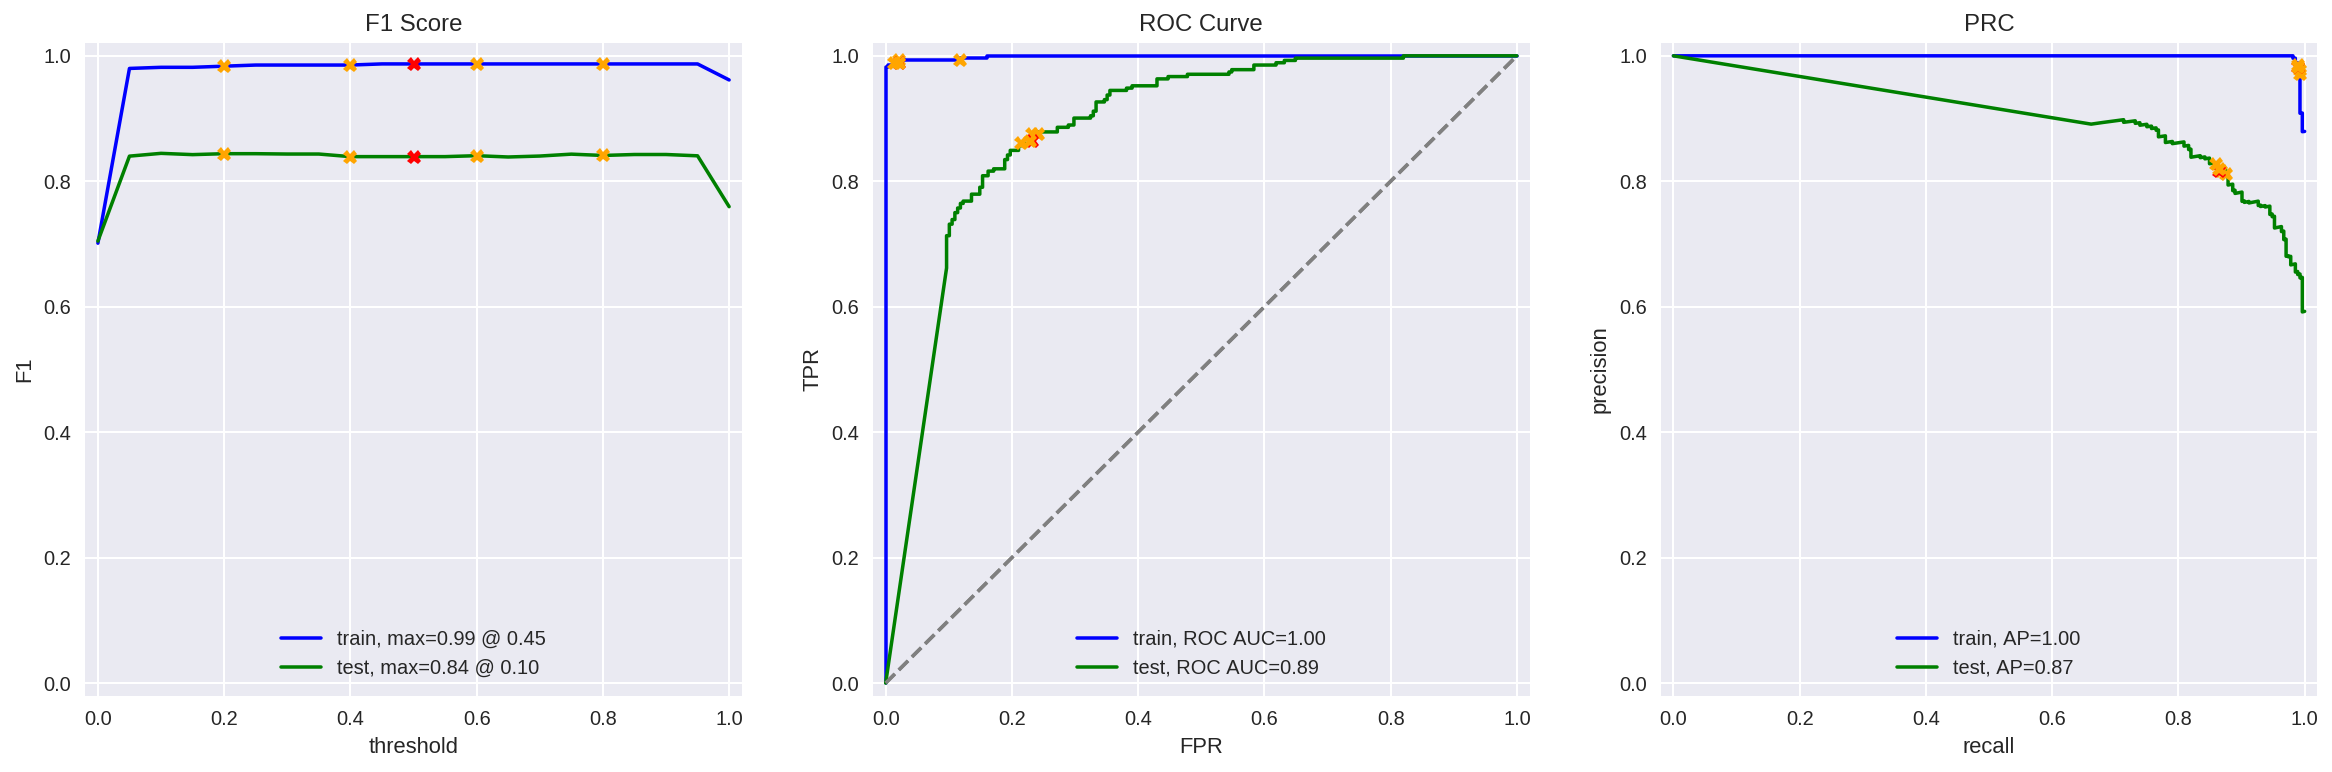

In [54]:
evaluate_model(sgd_clf_BERT, X_BERT_train, y_BERT_train, X_BERT_test, y_BERT_test)

**Conclusion**

- We've seen that:
    - using a maximum sample size of 500 for BERT embeddings, the computation took 49 minutes for train and test set. 
    - We can see that none of the models met the threshold score of 0.85 which was expected. The model that had a value closest to 0.85 for F1 score was the stochastic gradient descent but with a lot of overfitting on the train set.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
BERT embeddings were generated correctly, and the models you trained have pretty decent performance for such small sample sizes
	  
</div>

## My Reviews

In [55]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# clean the review
my_reviews['review_norm'] = my_reviews['review'].apply(clean_data)
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 1: Logistic regression

In [56]:
texts = my_reviews['review_norm']

# make prediction with logistic regression classifier
log_pred = logistic_clf_spacy.predict(count_tf_idf.transform(texts))
log_pred_prob = logistic_clf_spacy.predict_proba(count_tf_idf.transform(texts))[:, 1]

# summarize the result
print(f'{sum(log_pred)} were predicted as positive out of {len(log_pred)} reviews.')
print('='*50)
print()
print('Pos:'+'  '+'Proba:'+'  '+'Actual review')
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'  {log_pred[i]}:   {log_pred_prob[i]:.2f}:  {review}')

1 were predicted as positive out of 8 reviews.

Pos:  Proba:  Actual review
  0:   0.16:  I did not simply like it, not my kind of movie.
  0:   0.14:  Well, I was bored and felt asleep in the middle of the movie.
  0:   0.44:  I was really fascinated with the movie
  0:   0.27:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
  0:   0.41:  I didn't expect the reboot to be so good! Writers really cared about the source material
  0:   0.37:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
  0:   0.11:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
  1:   0.91:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


### Model 2: LightGBM classifier

In [57]:
texts = my_reviews['review_norm']

# make predictions using lightGBM classifier
lgbm_pred = lgbm_clf_spacy.predict(count_tf_idf.transform(texts))
lgbm_pred_prob = lgbm_clf_spacy.predict_proba(count_tf_idf.transform(texts))[:, 1]

# summarize the result
print(f'{sum(lgbm_pred)} were predicted as positive out of {len(lgbm_pred)} reviews.')
print('='*50)
print()
print('Pos:'+'  '+'Proba:'+'  '+'Actual review')
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'  {lgbm_pred[i]}:   {lgbm_pred_prob[i]:.2f}:  {review}')

5 were predicted as positive out of 8 reviews.

Pos:  Proba:  Actual review
  1:   0.56:  I did not simply like it, not my kind of movie.
  0:   0.39:  Well, I was bored and felt asleep in the middle of the movie.
  1:   0.60:  I was really fascinated with the movie
  0:   0.47:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
  1:   0.69:  I didn't expect the reboot to be so good! Writers really cared about the source material
  1:   0.67:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
  0:   0.29:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
  1:   0.75:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


### Model 3: Stochastic gradient descent algorithm

In [61]:
texts = my_reviews['review_norm']

# make predictions using stochastic gradient descent classifier
sgd_pred = sgd_clf_spacy.predict(count_tf_idf.transform(texts))
sgd_pred_prob = sgd_clf_spacy.predict_proba(count_tf_idf.transform(texts))[:, 1]

# summarize the result
print(f'{sum(sgd_pred)} were predicted as positive out of {len(sgd_pred)} reviews.')
print('='*50)
print()
print('Pos:'+'  '+'Proba:'+'  '+'Actual review')
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'  {sgd_pred[i]}:   {sgd_pred_prob[i]:.2f}:  {review}')

1 were predicted as positive out of 8 reviews.

Pos:  Proba:  Actual review
  0:   0.21:  I did not simply like it, not my kind of movie.
  0:   0.24:  Well, I was bored and felt asleep in the middle of the movie.
  0:   0.45:  I was really fascinated with the movie
  0:   0.33:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
  0:   0.47:  I didn't expect the reboot to be so good! Writers really cared about the source material
  0:   0.37:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
  0:   0.18:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
  1:   0.84:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


**Conclusion**

- We can see that neither SGD nor Logistic Regression managed to detect positive from negative reviews;
    - from 4 positive and 4 negative reviews, it classified 1 of them as positive and the 7 others as negative.
- Wereas LGBM detected better;
    - from 4 positive and 4 negative reviews, it classified 5 of them as positive and the 3 others as negative.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Oh, okay, so you're only trying models which were trained on the spacy-lemmatized text for custom reviews, which solves the issue of using the same TfIdfVectorizer.
	  
</div>

# Conclusions

The goal of this project is to train a model to automatically detect negative reviews for the Film Junky Union.

We did this by following different steps:

- We've first of all explored the data by:
    - Loading it, and seen that it contains 47331 rows and 17 columns. 
    - Using EDA, we visualized over the years, the number of movies and observed that it increases until 2006.
    - We've also seen that the labels are equally distributed between the two classes. so the data is well balanced.

- After that, 
    - We cleaned and normalized texts. 
    - Lemmatized the words using NLTK and spaCy. 
    - Vectorized the texts using TF-IDF and BERT. 
    - We used  LightGBMClassifier, Logistic Regression and Stochastic Gradient Classifier(for BERT technique) by trying them with different text preprocessing techniques with those models.

- We concluded that:
    - LightGBMClassifier with spaCy is the best model that meets the required F1 score and accuracy, also for the execution time which was faster. 
    - We fed some words containing 4 positive and 4 negative reviews to the algorithm. 
    - The lightGBM classifier emerged as the best performing model with an F1 score of 0.86, and was useful in detecting negative reviews by classifing 5 of the reviews as positive and the remaining 3 as negative. 
    - To automatically detect negative reviews from movie reviews, the LightGBM algorithm is the best performing algorithm for this task.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Very good!
	  
</div>

# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions